# 机器学习工程师纳米学位
## 算式识别

---
## 1. 数据探索


导入数据：

In [1]:
import numpy as np
import pandas as pd
import os
os.sys.path.append('/anaconda3/envs/style-transfer/lib/python2.7/site-packages')
%matplotlib inline

import cv2
import cv2 as cv

data_root_dir = ''
data = pd.read_csv('train.csv')
# display(data.describe())
print('data format:')
print(data.head(n=5))

data format:
      filename      label
0  train/0.jpg  (0+0)+9=9
1  train/1.jpg   9*8+6=78
2  train/2.jpg    1+7+0=8
3  train/3.jpg   5+4+9=18
4  train/4.jpg  7-(1*7)=0


分割训练集与测试集：

In [2]:
from sklearn.model_selection import train_test_split

data_train, data_test = train_test_split(data, test_size=0.2, random_state=42)
print('train data size:', len(data_train))
print('test data size:', len(data_test))

print(data_train.head(n=3))

train data size: 80000
test data size: 20000
              filename        label
75220  train/75220.jpg   8+(0-9)=-1
48955  train/48955.jpg    7-(8*0)=7
44966  train/44966.jpg  8*(8*3)=192


输入数据都是300x64的图片，每张图片中包含一个算式，并且有一个其代表的算式标签。在所有输入的数据中，算式总共有以下三类：  
x+x+x=x  
(x+x)+x=x  
x+(x+x)=x  
并且'='左边的数字均为个位数，相应代表的样本如下：
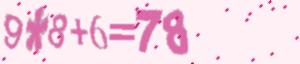
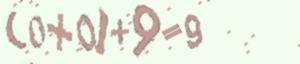
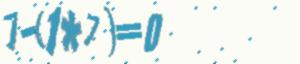
我们将训练集和测试集所有算式中的字符进行统计，结果如下：

labels: ['(', ')', '*', '+', '-', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '=']
each char counts: [  66487.   66487.   66668.   66517.   89396.   46522.   64228.   51072.
   44442.   45867.   42278.   42535.   38880.   40008.   37251.  100000.]
total char counts: 908638.0
3 type of sequence counts: [ 33513.  33224.  33263.] [ 0.33513  0.33224  0.33263]


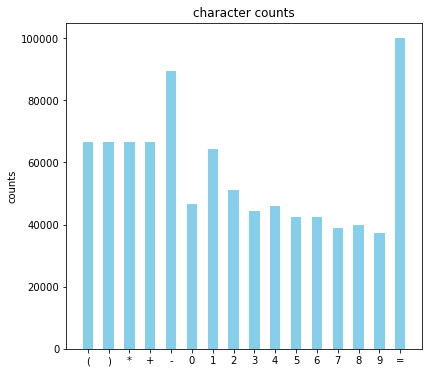

In [4]:
import matplotlib.pyplot as plt
import pprint
# calculate char distribution
type_train = 0
type_test = 1
type_all = 2
data_types = [type_train, type_test, type_all]
# data_types = [type_all]
char_counts = np.zeros((len(data_types), 16)) # each char counts in train and test
total_counts = np.zeros((len(data_types))) #total char counts in train and test
sequence_counts = np.zeros((len(data_types), 3)) #[[x+x+x=x, (x+x)+x=x, x+(x+x)=x]in train, []in test]
char_befor = np.zeros((len(data_types), 16)) #char before '=', [dict in train, dict in test]
char_after = np.zeros((len(data_types), 16)) #char after '=', [dict in train, dict in test]
char_labels = ['(', ')', '*', '+', '-', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '=']
results=[[],[],[]]

def calSeqCounts(ind, char_list):
    if '(' in char_list:
        if '(' == char_list[0]:
            sequence_counts[ind][1] += 1
        else:
            sequence_counts[ind][2] += 1
    else:
        sequence_counts[ind][0] += 1

def itrate_date(data, data_type):
    for j,string in enumerate(data):
        str_list = list(string)
        calSeqCounts(data_type, str_list)
        total_counts[data_type] += len(str_list)
        eq_index = str_list.index('=')
        seq_result = int(string[eq_index+1:])
        results[data_type].append(seq_result)
        for i,char in enumerate(str_list):
            if char == '-' and i == 0:
                print(j, string)
            char_index = char_labels.index(char)
            if i < eq_index:
                char_befor[data_type][char_index] += 1
            elif i > eq_index:
                char_after[data_type][char_index] += 1
            char_counts[data_type][char_index] += 1
# itrate_date(data_train['label'], 0)
# itrate_date(data_test['label'], 1)
itrate_date(data['label'], type_all)

print('labels:', char_labels)
print('each char counts:', char_counts[type_all])
print('total char counts:', total_counts[type_all])
print('3 type of sequence counts:', sequence_counts[type_all], sequence_counts[type_all]/len(data))
# print('=======in train data========')
# print('char_counts:', char_counts[type_train])
# print('total train char counts:', total_counts[0])
# print('train sequence counts:', sequence_counts[0], sequence_counts[0]/80000)

# print('=======in test data========')
# print('char_counts:', char_counts[type_test])
# print('total test char counts:', total_counts[1])
# print('test sequence counts:', sequence_counts[1], sequence_counts[1]/20000)

# display
width = 0.5
ticks = np.arange(len(char_counts[type_all]))
color = 'skyblue'

fig = plt.figure(figsize = (14,6))
data_type = type_all
ax_total_char = fig.add_subplot(1,2,1)
ax_total_char.bar(ticks, char_counts[data_type], width, color=color)
ax_total_char.set_title('character counts')
ax_total_char.set_ylabel('counts')
ax_total_char.set_xticks(ticks)
ax_total_char.set_xticklabels(char_labels)

# fig = plt.figure(figsize = (14,6))
# axs = []
# width = 0.5
# ticks = np.arange(len(char_counts[0]))
# for data_type in data_types:
#     axs.append(fig.add_subplot(1, 2, data_type + 1))
#     color = 'skyblue' if data_type == type_train else 'salmon'
#     axs[data_type].bar(ticks, char_counts[data_type], width, color=color)
#     title = 'character count in train set' if data_type == type_train else 'character count in test set'
#     axs[data_type].set_title(title)
#     axs[data_type].set_ylabel('counts')
#     axs[data_type].set_xticks(ticks)
#     axs[data_type].set_xticklabels(char_labels)

# fig2 = plt.figure(figsize = (14,12))
# ax_eq = []
# for index in np.arange(4):
#     ax_eq.append(fig2.add_subplot(2, 2, index + 1))
#     data_type = index % len(data_types)
#     color = 'skyblue' if data_type == type_train else 'salmon'
#     data_str = 'train data' if data_type == type_train else 'test data'
#     y_data = char_befor if index < 2 else char_after
#     title = 'character counts before \'=\' in '+data_str if index < 2 else 'character counts after \'=\' in '+data_str
#     ax_eq[index].set_title(title)
#     ax_eq[index].bar(ticks, y_data[data_type], width, color=color)
#     ax_eq[index].set_xticks(ticks)
#     ax_eq[index].set_xticklabels(char_labels)
    
# # hist of result after '='    
# fig3 = plt.figure(figsize = (14,6))
# ax_results = []
# ticks_results = np.arange(start=-50, stop=50,step=10)
# hist_counts = [[], []]
# hist_bins = [[], []]
# bins = np.arange(-50, 110, 10)
# for data_type in data_types:
#     ax_results.append(fig3.add_subplot(1, 2, data_type + 1))
#     color = 'skyblue' if data_type == type_train else 'salmon'
#     hist_counts[data_type], hist_bins[data_type], patches = ax_results[data_type].hist(results[data_type], \
#                                                             bins=bins, color = color, edgecolor='black')

plt.show()

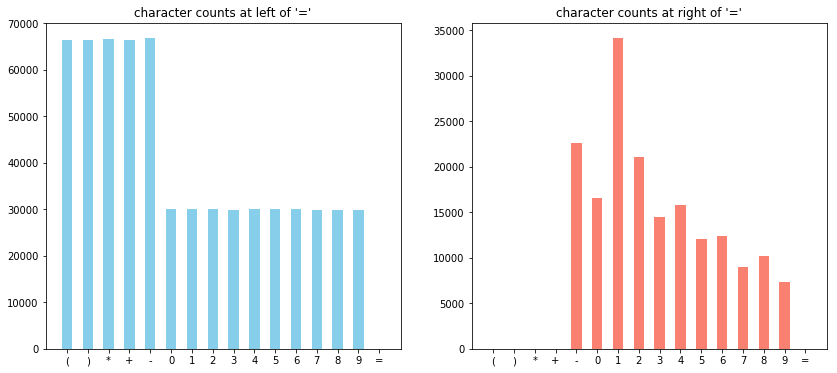

In [4]:
fig_eq = plt.figure(figsize = (14,6))
ax_eq = []
for index in np.arange(2):
    ax_eq.append(fig_eq.add_subplot(1, 2, index + 1))
    data_type = type_all
    color = 'skyblue' if index == 0 else 'salmon'
    y_data = char_befor if index == 0 else char_after
    title = 'character counts at left of \'=\'' if index == 0 else 'character counts at right of \'=\''
    ax_eq[index].set_title(title)
    ax_eq[index].bar(ticks, y_data[data_type], width, color=color)
    ax_eq[index].set_xticks(ticks)
    ax_eq[index].set_xticklabels(char_labels)

Text(0.5,1,'resuls at [-50,100)')

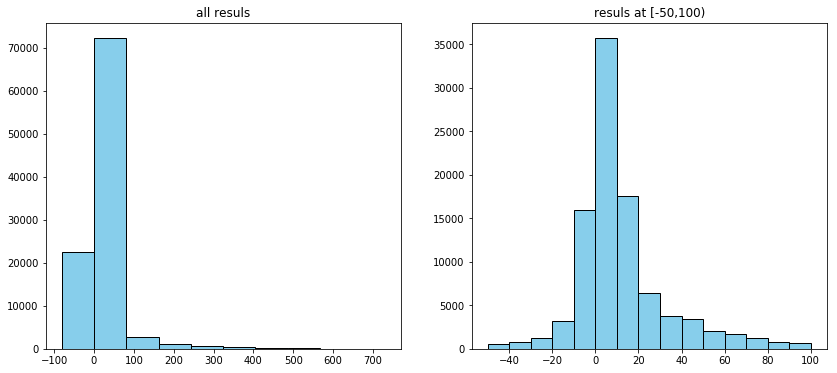

In [5]:
# hist of result after '='    
fig3 = plt.figure(figsize = (14,6))
ax_results = []
ticks_results = np.arange(start=-50, stop=50,step=10)
bins = np.arange(-50, 110, 10)

ax_hist = fig3.add_subplot(1, 2, 1)
color = 'skyblue'
# hist_counts, hist_bins, patches = ax_hist.hist(results[data_type], bins=bins, color = color, edgecolor='black')
hist_counts, hist_bins, patches = ax_hist.hist(results[data_type], color = color, edgecolor='black')
ax_hist.set_title('all resuls')

ax_hist2 = fig3.add_subplot(1, 2, 2)
ax_hist2.hist(results[data_type], bins=bins, color = color, edgecolor='black')
ax_hist2.set_title('resuls at [-50,100)')

通过观察和统计，我们发现以下一些特征和规律：  
一、对于每一种算式，其在训练集的占比分别为33.51%，33.11%，33.38%，在测试集的占比分别为33.53%，33.68%，32.79%，可见每种算式的概率基本相同，约为三分之一。  
二、各字符在总字符数的占比中，运算符'(',')','\*','+'的比例基本一致，而'-'偏多；为了解释此现象，我们统计了算式中'='前后各字符的数目，发现'='左边的运算符'(',')','\*','+','-'个数基本相同，各数字字符的个数也基本相同；但位于'='右边的字符中，运算符中只可能存在字符'-'，原因是运算结果可能为负数，但结果中不需要其他运算符。因此在算式的'='左边，各运算符出现的概率相同。  
三、各字符在总字符数中的占比中，数字字符中的‘1’数目明显多于其他数字，且其他数字字符从小到大存在递减趋势。因为结果中的数字分布受'='左侧的算式影响，而非平均概率分布，我们将每个算式结果的值进行统计画出直方图，为方便观察，图中展示了结果在[-50,100)区间的分布情况，可清晰的观察到[0,10)区间的值最多，其次为[10,20)，[-10,0)等，分布从中间向两边递减，由此可以解释为什么'='右边的数字字符中‘1’的个数最多，其他数字字符个数从小到达递减。因此在算式的'='左边，各数字的出现概率相同。  
四、每个算式中有且仅有一个'='字符。  
从以上几点可以看出数据样本在三种算式的分布上很平均，在算式的'='左侧选择运算符和数字的概率也很平均，因此数据很完整的覆盖了所有字符样本，可以作为可靠的输入，而且以上统计图中训练集的分布与测试集的分布基本一致，可以作为可靠的训练集和测试集。

In [6]:
import multiprocessing
from tqdm import tqdm

cores = multiprocessing.cpu_count()
pool = multiprocessing.Pool(processes=cores)

flat_array = []
def get_rgb(file_path):
    img = cv2.imread(file_path)
#     rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    ret = []
    for rgb_row in gray:
        for rgb_pix in rgb_row:
            ret.append(rgb_pix)
    return ret
            
file_paths=[]
a = 0
for filename, label in zip(data['filename'], data['label']):
    file_path = data_root_dir + filename
    file_paths.append(file_path)
    a += 1
    if a >= 5:
        break
print(cores, pool)
print(len(file_paths))
for file_path in file_paths:
    results = get_rgb(file_path)
    flat_array = flat_array + results
# for results in tqdm(pool.imap_unordered(get_rgb, file_paths), total=len(file_paths)):
# #     print(np.array(results).shape)
#     flat_array = flat_array + results
    
flat_array = np.array(flat_array)
print('loaded all gray pixels', flat_array.shape)

(4, <multiprocessing.pool.Pool object at 0x1a22713e10>)
5
('loaded all gray pixels', (96000,))


[  0   5  10  15  20  25  30  35  40  45  50  55  60  65  70  75  80  85
  90  95 100 105 110 115 120 125 130 135 140 145 150 155 160 165 170 175
 180 185 190 195 200 205 210 215 220 225 230 235 240 245 250 255 260]


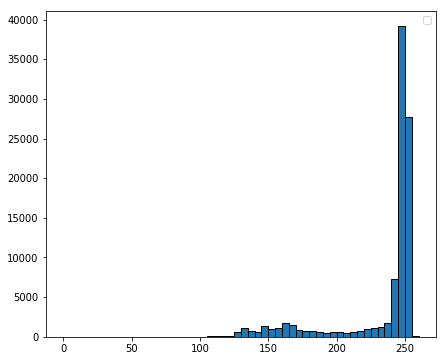

In [7]:

fig = plt.figure(figsize = (7,6))
ax = fig.add_subplot(1, 1, 1)
colors = ['salmon','springgreen','skyblue']
# bins = np.arange(0, 245, 5)
bins = np.arange(0, 265, 5)
print(bins)
n, bins, patchs = ax.hist(flat_array, edgecolor='black', bins=bins)#, label=['r','g','b'], color=colors)
ax.legend(prop={'size': 10})
plt.show()

In [8]:
gray_means = []
gray_std = []
a = 0
for filename, label in zip(data['filename'], data['label']):
    file_path = data_root_dir + filename
    file_paths.append(file_path)
    img = cv2.imread(file_path)
#     rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    gray_means.append(np.mean(gray))
    gray_std.append(np.std(gray))
    a += 1
    if a > 5:
        break
print(gray_means)
print(gray_std)

[233.86338541666666, 226.70911458333333, 232.80197916666665, 236.809375, 233.38635416666668, 239.13776041666668]
[29.129363639443856, 34.27816694959593, 30.77813340803661, 30.040722632387553, 37.843752253503695, 27.517063478581186]


## 2. 数据预处理

### 2.1转灰度图

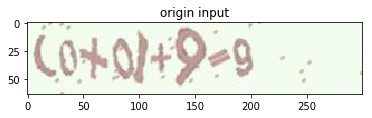

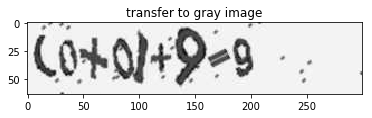

In [9]:

img = cv2.imread('0.jpg')
# cv2.imshow('image', img)
rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
plt.imshow(rgb)
plt.title('origin input')
plt.show()
plt.imshow(gray, cmap='gray')
plt.title('transfer to gray image')

# std_image = tf.image.per_image_standardization(rgb)
# with tf.Session() as sess:
#     result = sess.run(std_image)
#     print(result)
#     plt.imshow(result)
#     plt.title('transfer to standard image')

plt.show()

### 2.2提高对比度

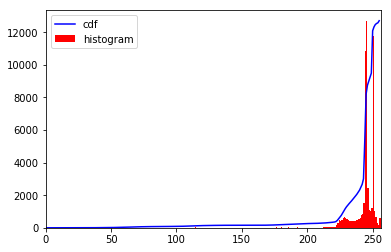

In [10]:
def show_img_hist(img):
    hist,bins = np.histogram(img.flatten(),256,[0,256])
    cdf = hist.cumsum()
#     print('flat', img.flatten())
#     print('hist', len(hist), np.sum(hist), hist)
#     print('cdf', len(cdf), np.sum(cdf), cdf)
#     print(hist.max(), cdf.max())
    cdf_normalized = cdf * float(hist.max()) / cdf.max()

    plt.plot(cdf_normalized, color = 'b')
    plt.hist(img.flatten(),256,[0,256], color = 'r')
    plt.xlim([0,256])
    plt.legend(('cdf','histogram'), loc = 'upper left')
    plt.show()
#     return cdf
img = cv2.imread('37.jpg')
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
show_img_hist(img)

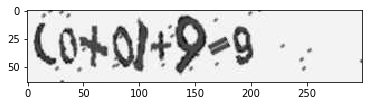

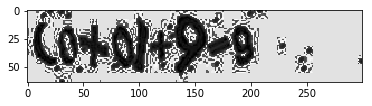

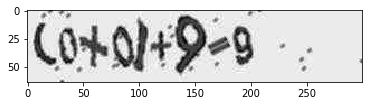

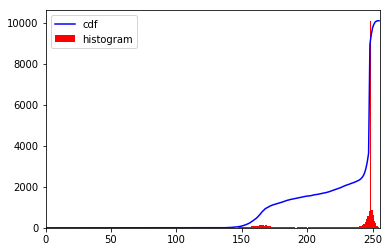

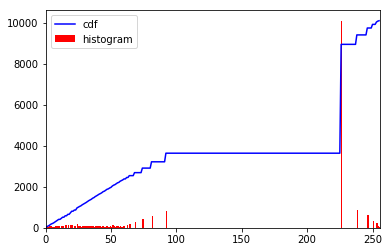

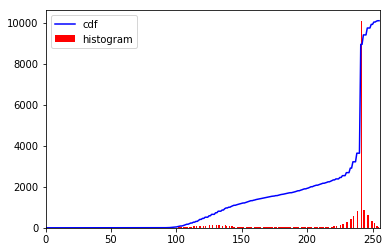

In [11]:
# cdf_m = np.ma.masked_equal(cdf,0)
# cdf_m = (cdf_m - cdf_m.min())*255/(cdf_m.max()-cdf_m.min())
# cdf = np.ma.filled(cdf_m,0).astype('uint8')
# img2 = cdf[img]
# show_img_hist(img2)
img = cv2.imread('0.jpg')
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
equ = cv.equalizeHist(gray)
clahe = cv.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
clahe2 = cv.createCLAHE(clipLimit=2.0, tileGridSize=(1,1))
clahe3 = cv.createCLAHE(clipLimit=4.0, tileGridSize=(1,1))
cl1 = clahe.apply(gray)
cl2 = clahe2.apply(gray)
cl3 = clahe3.apply(gray)
# res = np.hstack((gray,equ)) #stacking images side-by-side
# cv.imwrite('res.jpg',res)
plt.imshow(gray, cmap='gray')
plt.show()
plt.imshow(equ, cmap='gray')
plt.show()
# plt.imshow(cl1, cmap='gray')
# plt.show()
plt.imshow(cl2, cmap='gray')
plt.show()
# plt.imshow(cl3, cmap='gray')
# plt.show()
show_img_hist(gray)
show_img_hist(equ)
# show_img_hist(cl1)
show_img_hist(cl2)
# show_img_hist(cl3)

### 2.3 去除噪点

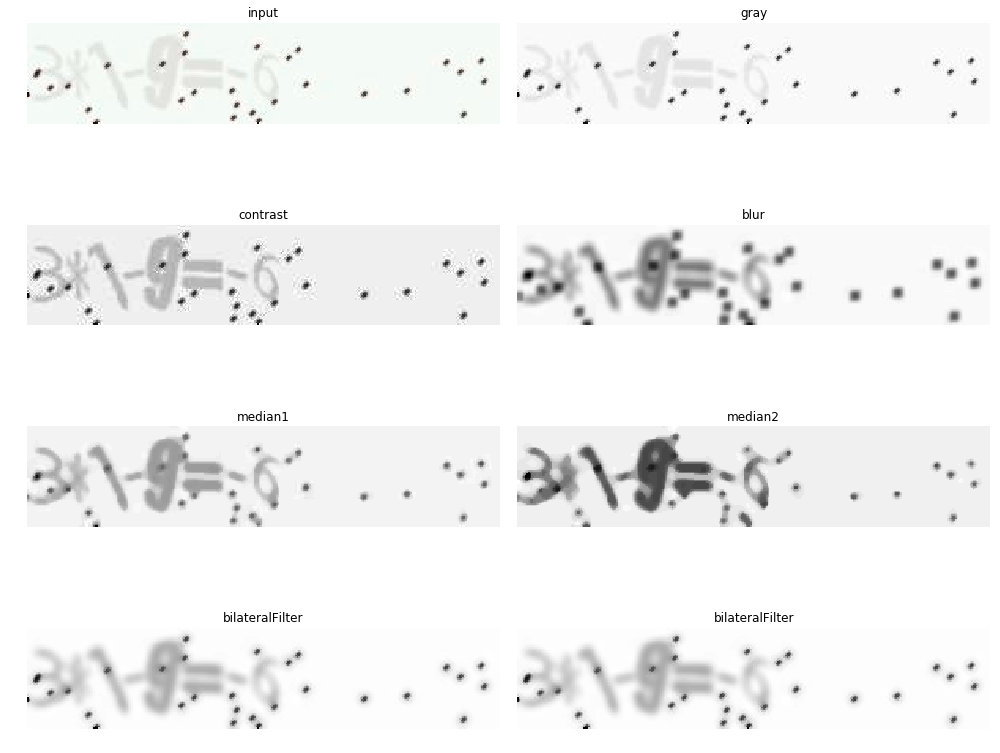

In [12]:
from skimage.restoration import (denoise_tv_chambolle, denoise_bilateral,
                                 denoise_wavelet, estimate_sigma)

ncols = 2
fig, ax = plt.subplots(nrows=4, ncols=ncols, figsize=(14, 12), sharex=True, sharey=True)

blurs = []
img = cv2.imread('37.jpg')
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

clahe = cv.createCLAHE(clipLimit=2.0, tileGridSize=(1,1))
cl1 = clahe.apply(gray)
contrast = cl1
blurs.append(img)
blurs.append(gray)
blurs.append(cl1)

blurs.append(cv.blur(contrast, (6,6)))
blurs.append(cv.medianBlur(contrast,5))
median = cv.medianBlur(contrast,5)
blurs.append(cv.medianBlur(median,5))

# blurs.append(cv.GaussianBlur(contrast,(5,5),0))
blurs.append(cv.bilateralFilter(contrast,9,75,75))
blurs.append(cv.bilateralFilter(contrast,9,75,175))
blur_name = ['input', 'gray', 'contrast', 'blur', 'median1', 'median2','bilateralFilter', 'bilateralFilter']
# blurs.append(denoise_bilateral(contrast, sigma_color=0.05, sigma_spatial=15, multichannel=False))
# blurs.append(denoise_bilateral(contrast, sigma_color=0.3, sigma_spatial=15, multichannel=False))
# blur_name = ['blur', 'median1', 'median2','denoise_bilateral', 'denoise_bilateral']

# plt.imshow(img)
# plt.title('input')
# plt.show()
# plt.imshow(gray, cmap='gray')
# plt.title('gray')
# cv.imwrite('gray.jpg',gray)
# plt.show()
# plt.imshow(cl1, cmap='gray')
# plt.title('cl1')
# plt.show()
index = 0
for b,name in zip(blurs, blur_name):
#     plt.imshow(b, cmap='gray')
#     plt.title(name)
#     plt.show()
    row = int(index / ncols)
    col = index%ncols
    if name == 'input':
        ax[row, col].imshow(b)
    else:
        ax[row, col].imshow(b, cmap='gray')
    ax[row, col].axis('off')
    ax[row, col].set_title(name)
    cv.imwrite('test/'+name+'.jpg',b)
    index += 1
fig.tight_layout()
plt.show()

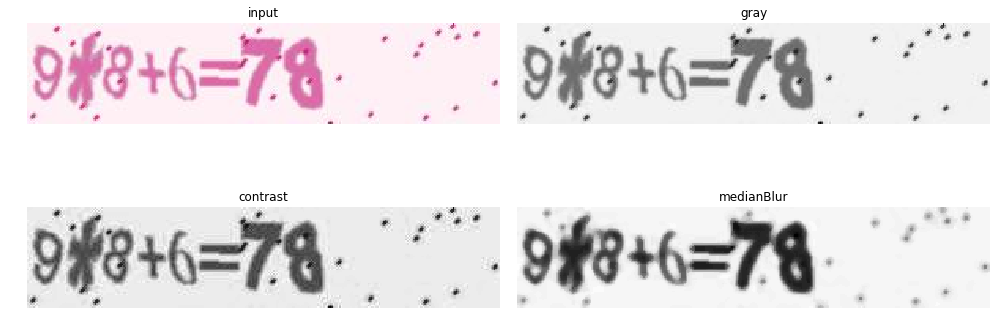

In [36]:
import time

k_size = 6
diff_thre = 40
def calPatch(patch, diffs):
    height, width = patch.shape
    side_width = 2
    side_sum = 0
    center_sum = 0
    side_n = 0
    center_n = 0
    for h in np.arange(height):
        for w in np.arange(width):
            pix_counts[patch[h][w]] += 1
            if h==0 or w==0 or h==height-side_width or w==width-side_width:
                side_sum += patch[h][w]
                side_n += 1
            else:
                center_sum += patch[h][w]
                center_n += 1
    side_mean = side_sum/side_n
    center_mean = center_sum/center_n
    diff = np.absolute(side_mean - center_mean)
    diffs.append(diff)
    if diff > diff_thre:
        bg_pix = np.where(pix_counts==np.max(pix_counts))[0][0]
        for h in np.arange(height):
            for w in np.arange(width):
                if h!=0 and w!=0 and h!=height-side_width and w!=width-side_width:
                    patch[h][w] = bg_pix#side_mean

def denoise(gray):
    height, width = gray.shape
    diffs = []
    pix_counts = np.zeros(256)#counts of each pix color
    for h in np.arange(height):
        for w in np.arange(width):
            if width - w >= k_size and height - h >= k_size:
                calPatch(gray[h:h+k_size,w:w+k_size], diffs)


img = cv2.imread('Mathematical_Expression_Recognition_train/train/1.jpg')
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
clahe = cv.createCLAHE(clipLimit=2.0, tileGridSize=(1,1))
cl1 = clahe.apply(gray)
# t = time.time()
# start_ms = (int(round(t * 1000)))
# img = cv2.imread('test/contrast.jpg')
# gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
# denoise(gray)
# t = time.time()
# end_ms = (int(round(t * 1000)))
# duration = end_ms - start_ms
# print('time elapse(ms):', duration) 

fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(14, 6), sharex=True, sharey=True)

rgb = cv.cvtColor(img, cv2.COLOR_BGR2RGB)
ax[0,0].imshow(rgb)
ax[0,0].axis('off')
ax[0,0].set_title('input')

ax[0,1].imshow(gray, cmap='gray')
ax[0,1].axis('off')
ax[0,1].set_title('gray')

# denoise(cl1)
ax[1,0].imshow(cl1, cmap='gray')
ax[1,0].axis('off')
ax[1,0].set_title('contrast')

blur = cv.medianBlur(cl1,5)
ax[1,1].imshow(blur, cmap='gray')
ax[1,1].axis('off')
ax[1,1].set_title('medianBlur')

fig.tight_layout()
plt.show()

# fig3 = plt.figure(figsize = (14,6))
# bins = np.arange(20, 120, 5)
# ax_hist = fig3.add_subplot(1, 2, 1)
# color = 'skyblue'
# ax_hist.hist(diffs, color = color, edgecolor='black')
# ax_hist2 = fig3.add_subplot(1, 2, 2)
# ax_hist2.hist(diffs, color = color, bins=bins, edgecolor='black')

In [37]:

def denoise_file(filepath, outpath):
    t = time.time()
    start_ms = (int(round(t * 1000)))
    img = cv2.imread(filepath)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    #contrast
    clahe = cv.createCLAHE(clipLimit=2.0, tileGridSize=(1,1))
    cl1 = clahe.apply(gray)
#     denoise(cl1)
    blur = cv.medianBlur(cl1,5)
    cv.imwrite(outpath,blur)
    t = time.time()
    end_ms = (int(round(t * 1000)))
    duration = end_ms - start_ms
#     print('time elapse(ms):', duration) 
    
a = 0
for filename, label in zip(data['filename'], data['label']):
    file_path = data_root_dir + filename
    name = filename[filename.index('/')+1:]
    out_path = 'preprocess/' + name
    denoise_file(file_path, out_path)
    a += 1
    print('process ' + file_path + ' to ' + out_path + ', finished')
    if a >= 3:
        break

process Mathematical_Expression_Recognition_train/train/0.jpg to preprocess/0.jpg, finished
process Mathematical_Expression_Recognition_train/train/1.jpg to preprocess/1.jpg, finished
process Mathematical_Expression_Recognition_train/train/2.jpg to preprocess/2.jpg, finished


In [2]:
import utils
import importlib
mod_utils = importlib.import_module('utils')
importlib.reload(mod_utils)

utils.preprocess_imgs()

data loaded, format:
      filename      label
0  train/0.jpg  (0+0)+9=9
1  train/1.jpg   9*8+6=78
2  train/2.jpg    1+7+0=8
process train/999.jpg to preprocess/999.jpg, finished, count = 1000
process train/1999.jpg to preprocess/1999.jpg, finished, count = 2000
process train/2999.jpg to preprocess/2999.jpg, finished, count = 3000
process train/3999.jpg to preprocess/3999.jpg, finished, count = 4000
process train/4999.jpg to preprocess/4999.jpg, finished, count = 5000
process train/5999.jpg to preprocess/5999.jpg, finished, count = 6000
process train/6999.jpg to preprocess/6999.jpg, finished, count = 7000
process train/7999.jpg to preprocess/7999.jpg, finished, count = 8000
process train/8999.jpg to preprocess/8999.jpg, finished, count = 9000
process train/9999.jpg to preprocess/9999.jpg, finished, count = 10000
process train/10999.jpg to preprocess/10999.jpg, finished, count = 11000
process train/11999.jpg to preprocess/11999.jpg, finished, count = 12000
process train/12999.jpg to pre

(32, 150)
(32, 150)


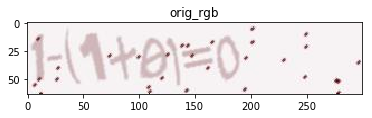

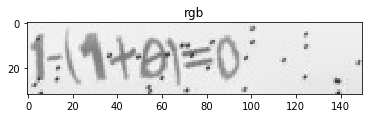

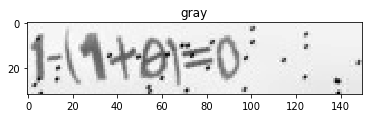

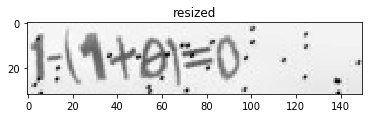

In [3]:

import cv2
import cv2 as cv
import matplotlib.pyplot as plt

file = '99999.jpg'
img = cv2.imread('train/'+file)
orig_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
filepath = 'preprocess/'+file
img = cv2.imread(filepath)
rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
h = gray.shape[0]
w = gray.shape[1]
ratio = float(32) / float(h)
dst_w = int(w * ratio)
resized = cv2.resize(gray, (dst_w, 32))#width=dst_w, height = 32
# print(gray[0])
print(gray.shape)
print(resized.shape)


plt.imshow(orig_rgb)
plt.title('orig_rgb')
plt.show()
plt.imshow(rgb)
plt.title('rgb')
plt.show()
plt.imshow(gray, cmap='gray')
plt.title('gray')
plt.show()
plt.imshow(resized, cmap='gray')
plt.title('resized')
plt.show()

In [7]:
import utils
import importlib
mod_utils = importlib.import_module('utils')
importlib.reload(mod_utils)

train_batches = utils.load_train_batches()

print(len(train_batches))
print(train_batches[0][0].shape)
print(train_batches[0][1])
print(train_batches[0][2].shape)

train data size: 80000
test data size: 20000
loading data... 
load_batches_internal, BATCH_SIZE: 128 batch_num: 625
batch: 0 --------------------------------------
batch finish: 0
batch: 1 --------------------------------------
batch finish: 1
batch: 2 --------------------------------------
batch finish: 2
load finished, elapsed: 0.05560636520385742 =============================================
3
(128,)
(array([[  0,   0],
       [  0,   1],
       [  0,   2],
       ..., 
       [127,   6],
       [127,   7],
       [127,   8]]), array([ 8, 10, 13, ..., 14, 15,  7], dtype=int32), array([128,  11]))
(128, 32, 150, 1)


In [17]:
import numpy as np
line = ['a.jpg abc', 'a2.jpg abc2', 'a3.jpg abc3']
# info = [['a.jpg', 'abc'], ['ab.jpg', 'abcd'], ['abc.jpg', 'abcde']]
info  = np.array(list(filter(lambda x: len(x) == 2,  # discard bogus entries with no label
                                            (l.strip().split(maxsplit=1) for l in line))))
print(info)
info = np.array([l.strip().split(maxsplit=1) for l in line])
print(l)
for x in info[:, 1]:
    print(x)
# labels = np.array([x for x in info[:, 1]])
# print(labels)

[['a.jpg' 'abc']
 ['a2.jpg' 'abc2']
 ['a3.jpg' 'abc3']]
[['a.jpg', 'abc'], ['a2.jpg', 'abc2'], ['a3.jpg', 'abc3']]
abc
abc2
abc3


In [1]:
import config

import importlib
mod_crnn = importlib.import_module('crnn')
importlib.reload(mod_crnn)
from crnn import CRNN

crnn = CRNN(
    batch_size=config.BATCH_SIZE, model_path = 'checkpoint/',
    max_image_width = 150, restore = False, debug = True, phase = 'train'
)

cnn_output: Tensor("conv2d_6/Relu:0", shape=(2, 1, 37, 512), dtype=float32)
Instructions for updating:
This class is deprecated, please use tf.nn.rnn_cell.LSTMCell, which supports all the feature this cell currently has. Please replace the existing code with tf.nn.rnn_cell.LSTMCell(name='basic_lstm_cell').
rnn_output: Tensor("bidirectional-rnn-2/concat:0", shape=(2, 37, 512), dtype=float32)
decoded: [<tensorflow.python.framework.sparse_tensor.SparseTensor object at 0x7f5de853d5c0>]
dense_decoded: Tensor("SparseToDense:0", shape=(?, ?), dtype=int64)


In [ ]:

import importlib
mod_crnn = importlib.import_module('crnn')
importlib.reload(mod_crnn)
from crnn import CRNN

crnn.train()

train data size: 80000
test data size: 20000
loading data... 
load_batches_internal, BATCH_SIZE: 2 batch_num: 40000
batch: 0 --------------------------------------
batch finish: 0
batch: 1 --------------------------------------
batch finish: 1
batch: 2 --------------------------------------
batch finish: 2
load finished, elapsed: 0.004591703414916992 =============================================
Training
trining step 0:
(2,)
(array([[0, 0],
       [0, 1],
       [0, 2],
       [0, 3],
       [0, 4],
       [0, 5],
       [0, 6],
       [0, 7],
       [0, 8],
       [0, 9],
       [1, 0],
       [1, 1],
       [1, 2],
       [1, 3],
       [1, 4],
       [1, 5],
       [1, 6],
       [1, 7],
       [1, 8]]), array([ 8, 10, 13,  0, 11,  9, 14, 15, 11,  1,  7, 11, 13,  8, 12,  0, 14,
       15,  7], dtype=int32), array([ 2, 10]))
(2, 32, 150, 1)


In [1]:
import tensorflow as tf
# Creates a graph.
a = tf.constant([1.0, 2.0, 3.0, 4.0, 5.0, 6.0], shape=[2, 3], name='a')
b = tf.constant([1.0, 2.0, 3.0, 4.0, 5.0, 6.0], shape=[3, 2], name='b')
c = tf.matmul(a, b)
# Creates a session with log_device_placement set to True.
sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))
# Runs the op.
print(sess.run(c))

[[ 22.  28.]
 [ 49.  64.]]
